In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.lines import Line2D 
import random
import copy
from itertools import combinations

In [ ]:
#### DEFINE A TOPOLOGIA DA REDE E VARIÁVEIS INICIAIS
def set_up_configuration(n_cells=400, k_neighbors=8, p_rewire=0.1,normalize=(0,0.25), distribution_type='random'):
    """
    Configura um grafo de Pequeno Mundo (Watts-Strogatz) com atributos de nós.
    Baseado no artigo, mas a estrutura é um grafo, não uma grade.
    k_neighbors: Número de vizinhos iniciais no anel. Valor par.
    p_rewire: Probabilidade de religação de arestas (criação de atalhos).
    """
    # Cria o grafo de pequeno mundo
    G = nx.watts_strogatz_graph(n=n_cells, k=k_neighbors, p=p_rewire, seed=32)

    # Parametros para taxas individuais (heterogeneidade)
    # Lógica de normalização mantida do código original
    minN, maxN = normalize
    if maxN == 1 and minN == 0:
        raw_q = np.random.uniform(minN,maxN,n_cells)    
        raw_r = np.random.uniform(minN,1 - raw_q,n_cells)
    else:
        raw_q = np.random.uniform(minN, maxN, n_cells)
        raw_r = np.random.uniform(0, np.minimum(1, 1 - raw_q), n_cells)

    # Atribui os atributos a cada nó do grafo
    for i in G.nodes():
        G.nodes[i]['status'] = 0  # Inicia todos como Susceptibles (S)
        G.nodes[i]['learningCapability'] = np.abs(np.random.normal(loc=0.0, scale=1.0))
        G.nodes[i]['transferCapability'] = np.abs(np.random.normal(loc=0.0, scale=1.0))
        G.nodes[i]['forgettingRate'] = raw_r[i]
        G.nodes[i]['quittingRate'] = raw_q[i]
        G.nodes[i]['timesContactor'] = 0

    # Define os Disseminadores iniciais (5% do total)
    disseminators = n_cells * 5 // 100
    
    if distribution_type == 'random':
        disseminator_nodes = np.random.choice(G.nodes(), disseminators, replace=False)
        for node_id in disseminator_nodes:
            G.nodes[node_id]['status'] = 2 # Estado I
            
    elif distribution_type == 'monopolistic':
        # Seleciona um nó central e seus vizinhos como disseminadores
        center_node = 300 #n_cells // 2 
        nodes_to_set = list(nx.ego_graph(G, center_node, radius=4).nodes())[:disseminators]
        for node_id in nodes_to_set:
            G.nodes[node_id]['status'] = 2

    elif distribution_type == 'small-group':
        # Cria pequenos clusters de disseminadores em locais distintos
        num_groups = 4
        start_nodes = np.random.choice(G.nodes(), num_groups, replace=False)        
        for start_node in start_nodes:
            nodes_to_set = list(nx.ego_graph(G, start_node, radius=2).nodes())[:5]
            for node_id in nodes_to_set:  
                G.nodes[node_id]['status'] = 2 

    return G

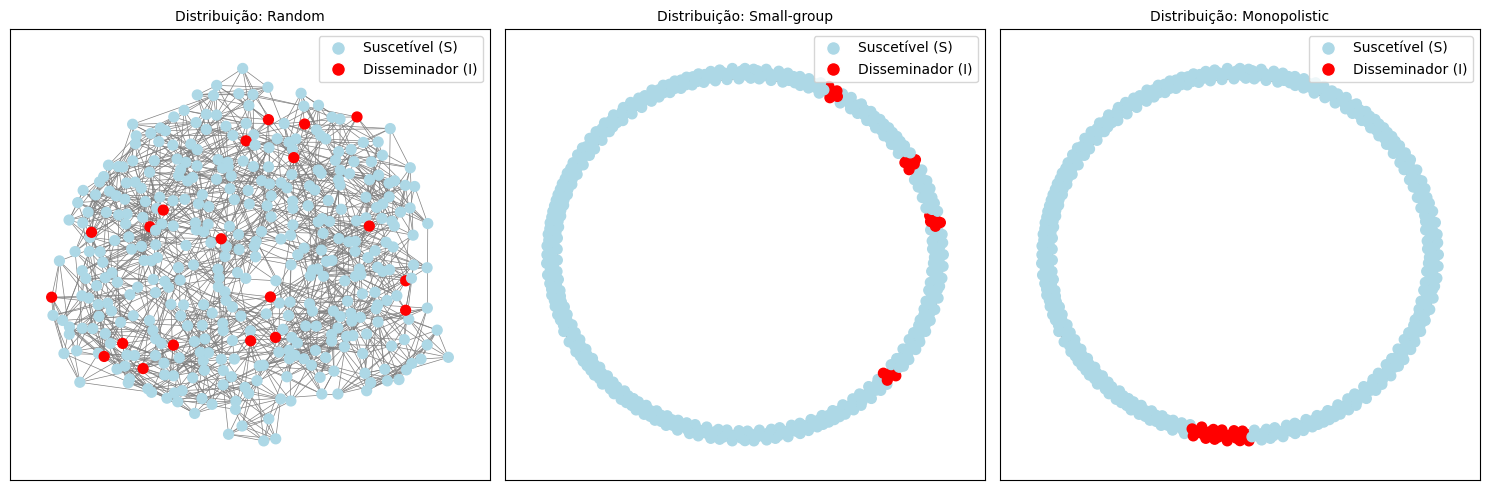

In [5]:
## Visualizar as configurações iniciais
def plot_initial_graph():
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    status_color_map = {
        0: 'lightblue',  # Suscetível (S) 
        1: 'yellow',     # Contatante (E) 
        2: 'red',        # Disseminador (I) 
        3: 'lightgreen', # Esquecedor (R) 
        4: 'gray'        # Desistente (Q) 
    }

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Suscetível (S)', markersize=10, markerfacecolor='lightblue'),
        Line2D([0], [0], marker='o', color='w', label='Disseminador (I)', markersize=10, markerfacecolor='red')
    ]

    distribution_type = ['random', 'small-group', 'monopolistic']
    for i, typeG in enumerate(distribution_type):
        if typeG == 'random':
            G = set_up_configuration(distribution_type=typeG)
        else:
            G = set_up_configuration(distribution_type=typeG,p_rewire=0)
        pos = nx.kamada_kawai_layout(G)
        node_colors = [status_color_map.get(G.nodes[n]['status'], 'black') for n in G.nodes()]   

        nx.draw_networkx(
            G,
            pos=pos,
            ax=axes[i],  # Desenhar no eixo correto
            with_labels=False,
            node_size=50,
            node_color=node_colors,
            width=0.5,
            edge_color='gray'
        )
        axes[i].set_title(f'Distribuição: {typeG.capitalize()}', fontsize=10)
        axes[i].legend(handles=legend_elements, loc='upper right')
        axes[i].set_xticks([])
        axes[i].set_yticks([])

    plt.tight_layout()
    plt.show()

plot_initial_graph()

In [6]:
def acquisition_rate(G, node_id):
    """
    Calcula a taxa de aquisição de conhecimento para um nó.
    A interação ocorre com os vizinhos diretos no grafo.
    A distância é implícita (1 para vizinhos diretos)
    """
    # Capacidade de aprendizado do nó atual (S ou R)
    lc_current = G.nodes[node_id]['learningCapability']
    
    max_tax = 0
    # Itera sobre os vizinhos diretos do nó no grafo
    for indices in G.neighbors(node_id):
        if G.nodes[indices]['status'] == 2:  # Se o vizinho é um Disseminador (I)
            tc_vizinho = G.nodes[indices]['transferCapability']
            
            # Fórmula de aquisição adaptada do artigo (sem o termo de distância)
            tax = lc_current * tc_vizinho 
            
            if tax > max_tax:
                max_tax = tax
                
    return max_tax

In [5]:
def apply_transition_S_to_E(G):  ## função para teste
    transicoes = 0

    for i in G.nodes():
        if G.nodes[i]['status'] == 0:
            taxa = acquisition_rate(G, i)
            if taxa > np.random.random() :
                transicoes += 1
                
    print(f'Total de transições S → E realizadas: {transicoes}')

G = set_up_configuration() 
apply_transition_S_to_E(G)

Total de transições S → E realizadas: 71


In [7]:
def transition_F(G):
    """
    Aplica as regras de transição de estado para cada nó no grafo.
    Esta lógica é praticamente idêntica à do modelo AC, pois é baseada nos atributos do nó.
    """
    # Cria um dicionário para armazenar as mudanças de estado do próximo passo
    next_states = {}
    
    for node_id in G.nodes():
        status = G.nodes[node_id]['status']
        D = G.nodes[node_id]['timesContactor']
        
        # Transição de Susceptível (S) para Contatante (E)
        if status == 0:
            taxa = acquisition_rate(G, node_id)
            if taxa > np.random.random():
                next_states[node_id] = {'status': 1, 'timesContactor': D + 1}

        # Transição de Contatante (E) para I, R ou Q
        elif status == 1:
            txR_base = G.nodes[node_id]['forgettingRate']
            txQ_base = G.nodes[node_id]['quittingRate']
            
            # Reforço de aprendizado
            Rl = txR_base ** (D + 1)
            Ql = txQ_base ** (D + 1)
            Il = 1 - Rl - Ql

            if Il < 0: 
                Il = 0
                total = Rl + Ql
                if total > 0:
                    Rl /= total
                    Ql /= total

            r = np.random.rand()
            if r < Ql:
                next_states[node_id] = {'status': 4}  # Q - Desistente
            elif r < Ql + Rl:
                lc_current = G.nodes[node_id]['learningCapability']
                new_lc = lc_current ** (1.0 / (D + 1.0)) if D >= 0 and lc_current > 0 else lc_current
                next_states[node_id] = {'status': 3, 'learningCapability': new_lc} # R - Esquecedor
            else:
                next_states[node_id] = {'status': 2}  # I - Disseminador

        # Transição de Esquecedor (R) para Contatante (E)
        elif status == 3:
            taxa = acquisition_rate(G, node_id)
            if taxa > np.random.random():
                 next_states[node_id] = {'status': 1} # Volta a ser Contatante
    
    # Aplica as mudanças de estado ao grafo
    for node_id, updates in next_states.items():
        for attr, value in updates.items():
            G.nodes[node_id][attr] = value
            
    return G

In [8]:
def mobility(G, IM=0, MD=0, all_valid_pairs=0):
    """
    Realiza trocas aleatórias entre pares de nós no grafo. 
    IM = Percentual de indivíduos (nós) que vão ser trocados   
    MD = Distância do movimento - No caso do artigo que é uma grade o valor máximo é 20 
         aqui na rede o valor máximo é o diâmetro dos nós 
    """

    if MD == 0 or IM == 0: # se for diferente disso não tem mobilidade 
        return G
    
    all_valid_pairs = []
    nodes = list(G.nodes())
    dist = MD * 20
    for n1, n2 in combinations(nodes, 2):
        if n1 <= dist and n2 <= dist:
            all_valid_pairs.append((n1, n2))

    #print('Tamanho trocas: ',len(all_valid_pairs))
      
    num_nos = G.number_of_nodes()
    num_to_move = (num_nos * IM) // 100

    #Evitar trocas repetidas por nó
    trocados = set()
    trocas = 0
    for _ in range(num_to_move):
        # 1. Sorteia um índice aleatório
        indice_sorteado = random.randint(0, len(all_valid_pairs) - 1)

        # 2. Pega o par correspondente a esse índice
        n1, n2 = all_valid_pairs[indice_sorteado]
        if n1 in trocados or n2 in trocados:
            continue

        # === Trocar atributos ===
        attrs_n1 = copy.deepcopy(G.nodes[n1])
        attrs_n2 = copy.deepcopy(G.nodes[n2])
        G.nodes[n1].update(attrs_n2)
        G.nodes[n2].update(attrs_n1)

        # === Salva vizinhos ANTES de remover arestas ===
        neighbors_n1 = list(G.neighbors(n1))
        neighbors_n2 = list(G.neighbors(n2))

        # === Remove conexões ===
        for neighbor in neighbors_n1:
            if G.has_edge(n1, neighbor):
                G.remove_edge(n1, neighbor)
        for neighbor in neighbors_n2:
            if G.has_edge(n2, neighbor):
                G.remove_edge(n2, neighbor)

        # === Recria conexões trocadas ===
        for neighbor in neighbors_n2:
            if neighbor != n1:
                G.add_edge(n1, neighbor)
        for neighbor in neighbors_n1:
            if neighbor != n2:
                G.add_edge(n2, neighbor)

        trocados.update([n1, n2])
        trocas += 1
                
    return G

In [9]:
def simular_difusao(G_initial, MD=0, IM=0, max_iter=50):
    """
    Executa a simulação de difusão de conhecimento no grafo.
    A função de mobilidade foi removida, pois os "atalhos" da SWN cumprem nativamente o papel da "mobilidade". *****VALIDAR*****
    """
    G = G_initial.copy()
    history_stats = []   

    for passo in range(1, max_iter + 1):
        G = transition_F(G)
        
        # Coleta estatísticas
        all_statuses = [data['status'] for _, data in G.nodes(data=True)]
        status_counts = {s: all_statuses.count(s) for s in range(5)}

        if MD > 0 and IM > 0:
            G = mobility(G, IM=IM, MD=MD)
        
        history_stats.append({
            'ciclo': passo,
            **{f'status_{s}': status_counts.get(s, 0) for s in range(5)}
        })
        
    return pd.DataFrame(history_stats)

In [10]:
def plot_results(results_dict, title_prefix, filename, colors=None, linestyles=None, n_cells=400):
    """
    Função genérica para plotar os resultados de qualquer experimento.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    for name, df_history in results_dict.items():
        df_history['r_t'] = df_history['status_2'] / n_cells
        df_history['v_t'] = df_history['status_2'].diff().fillna(0)
        ax1.plot(df_history['ciclo'], df_history['r_t'], label=name,
                 color=colors.get(name) if colors else None,
                 linestyle=linestyles.get(name) if linestyles else '-', marker='o', markersize=3)
        ax2.plot(df_history['ciclo'], df_history['v_t'], label=name,
                 color=colors.get(name) if colors else None,
                 linestyle=linestyles.get(name, '--') if linestyles else '--', marker='x', markersize=4)
    ax1.set_title('(a) Proporção de Disseminadores vs. Tempo')
    ax1.set_xlabel('Ciclos de Tempo')
    ax1.set_ylabel('Proporção de Disseminadores ($r_t$)')
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.legend()
    ax1.set_ylim(0, 1.05)
    ax1.set_xlim(0, 50)
    ax2.set_title('(b) Velocidade de Difusão vs. Tempo')
    ax2.set_xlabel('Ciclos de Tempo')
    ax2.set_ylabel('Novos Disseminadores ($v_t$)')
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.legend()
    ax2.set_xlim(0, 50)
    fig.suptitle(title_prefix, fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(filename, dpi=300)
    print(f"Gráficos salvos com sucesso no arquivo '{filename}'\n")
    plt.close(fig)

In [11]:
# --- FUNÇÕES DE EXECUÇÃO DOS EXPERIMENTOS --- 
def run_experiment_figure_4(k_neighbors=8, p_rewire=0.1,normalize=(0,0.25), MD=0, IM=0,rodadas=50):
    """Executa as simulações para replicar a Figura 4 usando o modelo SWN."""
    print("--- Iniciando simulações (SWN): Impacto da Distribuição Inicial ---")
    NUM_RODADAS = rodadas
    scenarios = ['random', 'small-group', 'monopolistic']
    results = {}
    
    for scenario in scenarios:
        print(f"  Executando cenário: {scenario.capitalize()} - ({NUM_RODADAS} rodadas)...")
        rodadas_history = []
        for i in range(NUM_RODADAS):
            np.random.seed(i)
            initial_graph = set_up_configuration(k_neighbors=k_neighbors, p_rewire=p_rewire,normalize=normalize, distribution_type=scenario)
            history = simular_difusao(initial_graph, MD=MD, IM=IM)
            rodadas_history.append(history)
        
        avg_history = pd.concat(rodadas_history).groupby('ciclo').mean().reset_index()
        results[scenario.capitalize()] = avg_history
        
    plot_results(results,
                 'Impacto da Distribuição Inicial - (SWN)',
                 'figura_4_simulacao_swn.png',
                 colors={'Random': 'green', 'Small-group': 'orange', 'Monopolistic': 'blue'},
                 linestyles={'Random': '-', 'Small-group': '--', 'Monopolistic': ':'})

def run_experiment_figure_5(p_rewire=0.1,normalize=(0,0.25), distribution_type='random', MD=0, IM=0,rodadas=50):
    """Executa as simulações para replicar a Figura 5 usando o modelo SWN."""
    print("--- Iniciando simulações (SWN): Impacto da Vizinhança ---")
    NUM_RODADAS = rodadas
    scenarios = {
        ' 4 Vizinhos': {'type': 4},
        ' 8 Vizinhos': {'type': 8},
        '16 Vizinhos': {'type': 16},
        '24 Vizinhos': {'type': 24}
    }
    results = {}
    for name, params in scenarios.items():
        print(f"  Executando cenário: {name} - ({NUM_RODADAS} rodadas)...")
        rodadas_history = []
        for i in range(NUM_RODADAS):
            np.random.seed(i) # Semente diferente para cada rodada
            initial_graph = set_up_configuration(k_neighbors=params['type'], p_rewire=p_rewire,normalize=normalize, distribution_type=distribution_type)
            history = simular_difusao(initial_graph, MD=MD, IM=IM)
            rodadas_history.append(history)
        # Calcula a média dos resultados
        avg_history = pd.concat(rodadas_history).groupby('ciclo').mean().reset_index()
        results[name] = avg_history
    plot_results(results,
                 'Impacto da Acessibilidade ao Conhecimento (Vizinhança) - (SWN)',
                 'figura_5_simulacao_swn.png')

def run_experiment_figure_6(k_neighbors=8, p_rewire=0.1,normalize=(0,0.25), distribution_type='random', MD=5,rodadas=50):
    """Executa as simulações para replicar a Figura 6 usando o modelo SWN."""
    print("--- Iniciando simulações (SWN): Impacto da Proporção de Indivíduos Móveis (IM) ---")
    NUM_RODADAS = rodadas
    scenarios = [0, 20, 50, 100]
    results = {}

    for im_percent in scenarios:
        name = f'IM = {im_percent}%'
        print(f"  Executando cenário: {name} - ({NUM_RODADAS} rodadas)...")
        rodadas_history = []
        for i in range(NUM_RODADAS):
            np.random.seed(i) # Semente diferente para cada rodada
            initial_graph = set_up_configuration(k_neighbors=k_neighbors,p_rewire=p_rewire,normalize=normalize, distribution_type=distribution_type)  
            history = simular_difusao(initial_graph, MD=MD, IM=im_percent)
            rodadas_history.append(history)
        # Calcula a média dos resultados
        avg_history = pd.concat(rodadas_history).groupby('ciclo').mean().reset_index()
        results[name] = avg_history
    plot_results(results,
                 'Impacto da Proporção de Indivíduos Móveis (IM) - (SWN)',
                 'figura_6_simulacao_swn.png')

def run_experiment_figure_7(k_neighbors=8, p_rewire=0.1, normalize=(0,0.25), distribution_type='random',IM=20,rodadas=50):
    """Executa as simulações para replicar a Figura 7 usando o modelo SWN."""
    print("--- Iniciando simulações (SWN): Impacto da Distância de Movimento (MD) ---")
    NUM_RODADAS = rodadas
    scenarios = [0, 5, 10, 20]
    
    results = {}
    for md_dist in scenarios:
        name = f'MD = {md_dist}'
        print(f"  Executando cenário: {name} - ({NUM_RODADAS} rodadas)...")
        rodadas_history = []
        for i in range(NUM_RODADAS):
            np.random.seed(i) # Semente diferente para cada rodada
            initial_graph = set_up_configuration(k_neighbors=k_neighbors,p_rewire=p_rewire,normalize=normalize, distribution_type=distribution_type)  
            history = simular_difusao(initial_graph, MD=md_dist, IM=IM)
            rodadas_history.append(history)

        # Calcula a média dos resultados
        avg_history = pd.concat(rodadas_history).groupby('ciclo').mean().reset_index()
        results[name] = avg_history

    plot_results(results,
                 'Impacto da Distância Máxima de Movimento (MD) - (SWN)',
                 'figura_7_simulacao_swn.png')

def run_experiment_figure_8(k_neighbors=8, p_rewire=0.1,distribution_type='random',MD=0, IM=0,rodadas=50):
    """Executa as simulações para replicar a Figura 8 usando o modelo SWN."""
    print("--- Iniciando simulações (SWN): Impacto da Taxa de Desistência ---")
    NUM_RODADAS = rodadas
    # Interpretando a notação N(a,b) do artigo como uma distribuição Uniforme(a,b)
    # cenários do artigo seção 4.4
    scenarios = {
        'Taxa [0.00-0.25]': {'min': 0.00, 'max': 0.25},
        'Taxa [0.25-0.50]': {'min': 0.25, 'max': 0.50},
        'Taxa [0.50-0.75]': {'min': 0.50, 'max': 0.75},
        'Taxa [0.75-1.00]': {'min': 0.75, 'max': 1.00} 
    }
    results = {}
    for name, params in scenarios.items():
        print(f"  Executando cenário: {name} - ({NUM_RODADAS} rodadas)...")
        rodadas_history = []
        for i in range(NUM_RODADAS):
            np.random.seed(i) # Semente diferente para cada rodada
            initial_graph = set_up_configuration(k_neighbors=k_neighbors,p_rewire=p_rewire,normalize=(params['min'],params['max']), 
                                                 distribution_type=distribution_type)  
            history = simular_difusao(initial_graph, MD=MD, IM=IM)
            rodadas_history.append(history)

        # Calcula a média dos resultados
        avg_history = pd.concat(rodadas_history).groupby('ciclo').mean().reset_index()
        results[name] = avg_history

    plot_results(results,
                 'Impacto da Taxa de Desistência do Conhecimento - (SWN)',
                 'figura_8_simulacao_swn.png')
    
def run_experiment_figure_9(k_neighbors=8, p_rewire=0.1, normalize=(0,0.25), distribution_type='random',IM=0,MD=0,rodadas=50):
    print("--- Iniciando simulações (SWN): Impacto P(rewire) ---")
    NUM_RODADAS = rodadas
    #scenarios = [0, 0.02, 0.05, 0.10]  ## pior
    #scenarios = [0, 0.05, 0.10, 0.20]  
    scenarios = [0, 0.10, 0.20, 1]  ## melhor
    #scenarios = [0, 0.20, 0.40, 1]  
    #scenarios = [0, 0.25, 0.50, 1.00]  ## ruim
    
    results = {}
    for pr in scenarios:
        name = f'Pr = {pr}'
        print(f"  Executando cenário: {name} - ({NUM_RODADAS} rodadas)...")
        rodadas_history = []
        for i in range(NUM_RODADAS):
            np.random.seed(i) # Semente diferente para cada rodada
            initial_graph = set_up_configuration(k_neighbors=k_neighbors,p_rewire=pr,normalize=normalize, distribution_type=distribution_type)  
            history = simular_difusao(initial_graph, MD=MD, IM=IM)
            rodadas_history.append(history)

        # Calcula a média dos resultados
        avg_history = pd.concat(rodadas_history).groupby('ciclo').mean().reset_index()
        results[name] = avg_history

    plot_results(results,
                 'Impacto da Probabilidade de Religação - (SWN)',
                 'figura_9_simulacao_swn.png')


In [17]:
#run_experiment_figure_4(rodadas=50)
#run_experiment_figure_5(rodadas=50)
#run_experiment_figure_6(rodadas=50)
#run_experiment_figure_7(rodadas=50)
#run_experiment_figure_8(rodadas=50)
run_experiment_figure_9(rodadas=50)

print("\nTodos os experimentos foram concluídos com sucesso.")

--- Iniciando simulações (SWN): Impacto P(rewire) ---
  Executando cenário: Pr = 0 - (50 rodadas)...
  Executando cenário: Pr = 0.1 - (50 rodadas)...
  Executando cenário: Pr = 0.2 - (50 rodadas)...
  Executando cenário: Pr = 1 - (50 rodadas)...
Gráficos salvos com sucesso no arquivo 'figura_9_simulacao_swn.png'


Todos os experimentos foram concluídos com sucesso.


In [23]:
def religacao_dinamica(G, p_rewire, IM=0):
    """
    Realiza um passo de religação dinâmica na rede (parecido com o rewire)
    Args:
        G (nx.Graph): O grafo a ser modificado.
        p_rewire (float): A probabilidade de um nó tentar religar uma de suas arestas.
    """
     
    num_nos = G.number_of_nodes()
    num_to_move = (num_nos * IM) // 100

    #Evitar trocas repetidas por nó
    trocas = 0
    # Percorremos uma cópia da lista de nós para evitar problemas ao modificar o grafo
    for node in list(G.nodes()):

        if trocas > num_to_move:
            break
        trocas += 1
        # Verifica se o nó vai tentar uma religação nesta iteração
        if random.random() < p_rewire:
            # Pega a lista de vizinhos do nó atual
            vizinhos = list(G.neighbors(node))
            
            # Só continua se o nó tiver algum vizinho para trocar
            if not vizinhos:
                continue

            # 1. Escolhe aleatoriamente uma conexão para quebrar
            vizinho_para_remover = random.choice(vizinhos)
            G.remove_edge(node, vizinho_para_remover)

            # 2. Escolhe um novo nó para se conectar
            # Lista de candidatos: todos os nós, exceto o nó atual e seus vizinhos já existentes
            candidatos = [n for n in G.nodes() if n != node and not G.has_edge(node, n)]
            
            if not candidatos:
                # Se não houver candidatos, refaz a conexão original para não perder a aresta
                G.add_edge(node, vizinho_para_remover)
                continue
            
            novo_vizinho = random.choice(candidatos)
            G.add_edge(node, novo_vizinho)
            
            #print(f"🔄 Nó {node}: Quebrou conexão com {vizinho_para_remover} e conectou-se com {novo_vizinho}")
    return G

def simular_difusao2(G_initial, IM=0, p_rewire=0.1, max_iter=50):
    """
    Executa a simulação de difusão de conhecimento no grafo.
    A função de mobilidade foi removida, pois os "atalhos" da SWN cumprem nativamente o papel da "mobilidade". *****VALIDAR*****
    """
    G = G_initial.copy()
    history_stats = []   

    for passo in range(1, max_iter + 1):
        G = transition_F(G)
        
        # Coleta estatísticas
        all_statuses = [data['status'] for _, data in G.nodes(data=True)]
        status_counts = {s: all_statuses.count(s) for s in range(5)}

        if IM > 0:
            G = religacao_dinamica(G, p_rewire=p_rewire, IM=IM)
        
        history_stats.append({
            'ciclo': passo,
            **{f'status_{s}': status_counts.get(s, 0) for s in range(5)}
        })
        
    return pd.DataFrame(history_stats)

In [25]:
results = {}
NUM_RODADAS = 50
scenarios = [0, 0.10, 0.20, 1]
for pr in scenarios:
    name = f'Pr = {pr}'
    print(f"  Executando cenário: {name} - ({NUM_RODADAS} rodadas)...")
    rodadas_history = []
    for i in range(NUM_RODADAS):
        np.random.seed(i) # Semente diferente para cada rodada
        initial_graph = set_up_configuration(k_neighbors=8,p_rewire=0.1, distribution_type='random')  
        history = simular_difusao2(initial_graph, IM=10, p_rewire=pr)
        rodadas_history.append(history)

    # Calcula a média dos resultados
    avg_history = pd.concat(rodadas_history).groupby('ciclo').mean().reset_index()
    results[name] = avg_history

plot_results(results,
             'Impacto da Probabilidade de Religação - (SWN)',
             'teste.png')

  Executando cenário: Pr = 0 - (50 rodadas)...
  Executando cenário: Pr = 0.1 - (50 rodadas)...
  Executando cenário: Pr = 0.2 - (50 rodadas)...
  Executando cenário: Pr = 1 - (50 rodadas)...
Gráficos salvos com sucesso no arquivo 'teste.png'

